# Chapter 2: End-to-end Machine Learning Project

In [1]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.constant import BASE_PATH
from src.handson_ml.utils import fetch_tgz_data


In [2]:
# Download the data from books' repository and stored it in /data/ folder
fetch_tgz_data(path="housing/housing.tgz")

# Import the data
data_path = os.path.join(BASE_PATH, "data", "housing.csv")
housing = pd.read_csv(data_path)

# Look at data information
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


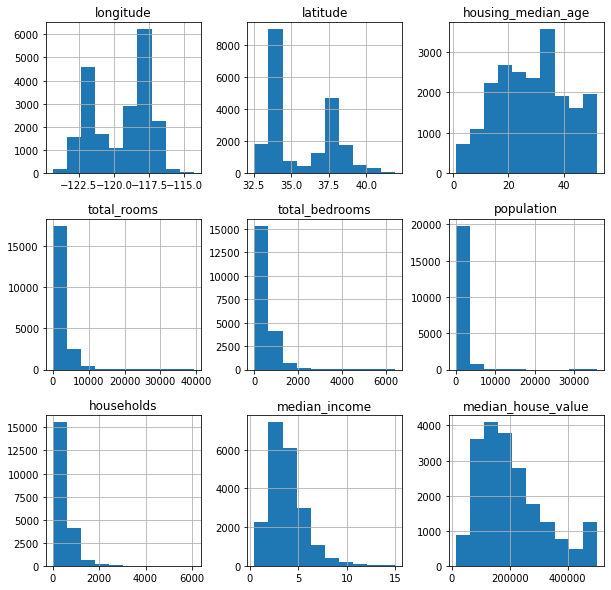

In [4]:
housing.hist(figsize=(10, 10))
plt.show()

## Section 1: Splitting the data into test / train set

In [5]:
# Manually create a function to split by random integer
def split_data_to_train_test(df: pd.DataFrame, test_percentage:float, seed:int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    n = df.shape[0]
    ix = np.arange(0, n)

    np.random.seed(seed)
    random_chance = np.random.random(len(ix))           # Random between 0 and 1
    is_test_set = random_chance < test_percentage

    test_ix = ix[is_test_set]
    train_ix = ix[~is_test_set]

    df_randomised = df.sample(random_state=seed, frac=1, replace=False).copy()

    return (df_randomised.iloc[train_ix, :], df_randomised.iloc[test_ix, :])

# Using sklearn's train test split
from sklearn.model_selection import train_test_split

# Using sklearn's stratified split
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
train, test = split_data_to_train_test(df = housing, test_percentage = 0.2, seed = 42)
train_dim, test_dim = train.shape[0], test.shape[0]

print("=== Manual split data function creation result ===")
print(f"Train dimension pct: {train_dim / (train_dim+test_dim)}")
print(f"Test dimension pct: {test_dim / (train_dim+test_dim)}")

# Test exclusivity of train and test set
def train_test_exclusivity_test(train_set:pd.DataFrame, test_set:pd.DataFrame) -> str:
    test_train_in_test = np.sum(train_set.index.isin(test_set.index))
    test_test_in_train = np.sum(test_set.index.isin(train_set.index))
    
    assert test_train_in_test == 0, "Leaked train data index in test data index"
    assert test_test_in_train == 0, "Leaked test data index in train data index"

    return 200, "OK - Passed train & test index exclusivity test"

train_test_exclusivity_test(train_set=train, test_set=test)

=== Manual split data function creation result ===
Train dimension pct: 0.8002422480620155
Test dimension pct: 0.1997577519379845


(200, 'OK - Passed train & test index exclusivity test')

In [7]:
train_skl, test_skl = train_test_split(housing, test_size = 0.2, random_state = 42)
train_skl_dim, test_skl_dim = train_skl.shape[0], test_skl.shape[0]

print(f"Train dimension pct: {train_skl_dim / (train_skl_dim+test_skl_dim)}")
print(f"Test dimension pct: {test_skl_dim / (train_skl_dim+test_skl_dim)}")

train_test_exclusivity_test(train_skl, test_skl)

Train dimension pct: 0.8
Test dimension pct: 0.2


(200, 'OK - Passed train & test index exclusivity test')

In [8]:
# Creating a median income category
housing["median_income_cat"] = pd.cut(
    x = housing["median_income"],
    bins = [0, 1.5, 3, 4.5, 6, np.inf],
    labels = [1, 2, 3, 4, 5]
)

# Get stratified split
stratified_split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_indices, test_indices in stratified_split.split(X=housing, y=housing["median_income_cat"]):
    train_stratified = housing.iloc[train_indices, :]
    test_stratified = housing.iloc[test_indices, :]

train_test_exclusivity_test(train_stratified, test_stratified)

# Get the random split
train_random, test_random = train_test_split(housing, test_size=0.2, random_state=42)

In [9]:
def create_row_distribution(data:pd.DataFrame, column:str, dist_colname:str="pct"):
    agg = data.groupby([column])\
        .aggregate(num_row = (column, "count"))\
        .reset_index()

    agg[dist_colname] = agg["num_row"] / np.sum(agg["num_row"])
    return agg.drop(columns = "num_row")

# Stratified split distribution
stratified_median_income_dist = create_row_distribution(
    data = train_stratified, column = "median_income_cat", dist_colname="pct_stratified"
)
# Random split distribution
random_median_income_dist = create_row_distribution(
    data = train_random, column = "median_income_cat", dist_colname="pct_random"
)
# Housing split distribution
housing_dist = create_row_distribution(
    data = housing, column = "median_income_cat", dist_colname="pct_overall"
)

result = pd.merge(
    left = housing_dist,
    right = stratified_median_income_dist,
    on = "median_income_cat",
    how = "left"
)
result = pd.merge(
    left = result,
    right = random_median_income_dist,
    on = "median_income_cat",
    how = "left"
)
result["stratified_error"] = np.abs((result["pct_stratified"] - result["pct_overall"])/result["pct_overall"])
result["random_error"] = np.abs((result["pct_random"] - result["pct_overall"])/result["pct_overall"])
result["startified_random_error_ratio"] = result["stratified_error"] / result["random_error"]
result

,median_income_cat,pct_overall,pct_stratified,pct_random,stratified_error,random_error,startified_random_error_ratio
0,1,0.039826,0.039789,0.039729,0.000912,0.002433,0.375000
1,2,0.318847,0.318859,0.317466,0.000038,0.004331,0.008772
2,3,0.350581,0.350594,0.348595,0.000035,0.005666,0.006098
3,4,0.176308,0.176296,0.178537,0.000069,0.012641,0.005435
4,5,0.114438,0.114462,0.115673,0.000212,0.010796,0.019608


**Section 1: Key takeaway**

Stratification is useful to be able to get a more representative sample. Especially during a classification task, we want to ensure that both test and train should have the same target distribution. Note that, without stratification, random sample gives *significantly* bigger error compared to the stratification method.

Note that, this split is good for one-time usage. If we need to do split in a incremental basis or when the data is changing frequently, having a unique-id in the dataset and split based on that unique-id should be helpful. The implementation is possible by computing hash value for each identifier. 